# 練習課堂範例程式碼與參考程式碼

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torch.nn.functional as F
import numpy as np

# torch.manual_seed(1)

EPOCH = 2
LR = 0.001
DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=torchvision.transforms.ToTensor(),
                                        download=DOWNLOAD_MNIST, )
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)

print(train_data.data.shape)
print(type(train_data))
print(test_data)
print(train_data.targets)

train_x = torch.unsqueeze(train_data.data, dim=1).type(torch.FloatTensor) / 255.
train_y = train_data.targets
print(train_x.shape)

test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000] / 255.  # Tensor on GPU
test_y = test_data.targets[:2000]


torch.Size([60000, 28, 28])
<class 'torchvision.datasets.mnist.MNIST'>
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist/
    Split: Test
tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([60000, 1, 28, 28])


In [3]:
test_x.shape

torch.Size([2000, 1, 28, 28])

In [4]:
import matplotlib.pyplot as plt

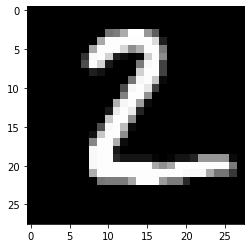

In [5]:
plt.imshow(test_x[1,0,:,:].numpy(), 'gray')

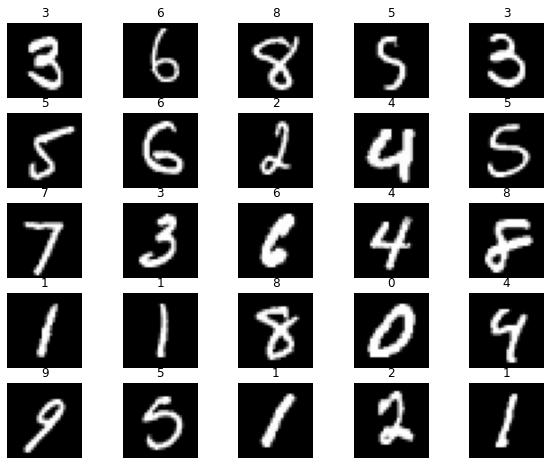

In [6]:
# 繪製多個 train_data
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
test_y[:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

# LeNet

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output
fc = LeNet()   
optimizer = torch.optim.Adam(fc.parameters(), lr=LR)
#loss_func = nn.MSELoss()
loss_func = nn.CrossEntropyLoss()

data_size = 50000
batch_size = 50
for epoch in range(EPOCH):
    random_indx = np.random.permutation(data_size)
    for batch_i in range(data_size // batch_size):
        indx = random_indx[batch_i * batch_size:(batch_i + 1) * batch_size]

        b_x = train_x[indx, :]
        b_y = train_y[indx]
#         print(b_x.shape)
#         print(b_y.shape)
        output = fc(b_x)
        loss = loss_func(output, b_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch_i % 50 == 0:
            test_output = fc(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            # pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = torch.sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.3f' % accuracy)

test_output = fc(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:10], 'real number')


Epoch:  0 | train loss: 2.3258 | test accuracy: 0.104
Epoch:  0 | train loss: 2.3098 | test accuracy: 0.108
Epoch:  0 | train loss: 2.3630 | test accuracy: 0.117
Epoch:  0 | train loss: 2.3079 | test accuracy: 0.117
Epoch:  0 | train loss: 2.2805 | test accuracy: 0.109
Epoch:  0 | train loss: 1.9630 | test accuracy: 0.542
Epoch:  0 | train loss: 1.5320 | test accuracy: 0.645
Epoch:  0 | train loss: 1.0320 | test accuracy: 0.739
Epoch:  0 | train loss: 0.9483 | test accuracy: 0.799
Epoch:  0 | train loss: 0.6263 | test accuracy: 0.817
Epoch:  0 | train loss: 0.6395 | test accuracy: 0.851
Epoch:  0 | train loss: 0.6217 | test accuracy: 0.861
Epoch:  0 | train loss: 0.3698 | test accuracy: 0.877
Epoch:  0 | train loss: 0.4216 | test accuracy: 0.886
Epoch:  0 | train loss: 0.5869 | test accuracy: 0.868
Epoch:  0 | train loss: 0.4163 | test accuracy: 0.890
Epoch:  0 | train loss: 0.4099 | test accuracy: 0.894
Epoch:  0 | train loss: 0.2348 | test accuracy: 0.900
Epoch:  0 | train loss: 0.31

In [9]:
import time
import torch
from torch import nn, optim

import sys
sys.path.append("..")
# import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = LeNet()
print(net)

input_img = torch.randn(16, 1, 32, 32)
print(input_img)
print(type(input_img))
output = net(input_img)
print(output.shape)


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
tensor([[[[ 1.5547,  1.6220,  0.1121,  ...,  1.2122,  0.0249, -1.5339],
          [-0.3216,  0.1290,  0.6823,  ..., -0.2353,  0.1027,  0.3830],
          [-1.0637, -0.0707,  0.4763,  ...,  0.2545, -1.2216,  0.3843],
          ...,
          [ 0.2419, -0.8775, -1.2603,  ..., -0.9049, -0.8951, -0.0384],
          [-0.3129,  1.3024,  0.0487,  ..., -0.1210,  0.3713, -0.5440],
          [ 0.5860, -0.5385, -1.0512,  ..., -0.5112, -0.8648,  0.6012]]],


        [[[ 0.9596, -0.8199, -1.1239,  ...,  0.1228,  0.6052, -0.5166],
          [ 1.6220, -0.6894,  0.4071,  ...,  0.3356, -1.3232, -0.8073],
          [-0.5643, -0.8382, -0.1070,  ...,  0.5183,  1.0867, -0.0151],
          ...,
       

# AlexNet

In [10]:
import time
import torch
from torch import nn, optim
import torchvision

import sys
sys.path.append("..")
# import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

net = AlexNet()
print(net)

input_img = torch.randn(16, 1, 224, 224)
output = net(input_img)
print(output.shape)


AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

# VGG

In [11]:
import time
import torch
from torch import nn, optim

import sys
sys.path.append("..")
# import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def vgg_block(num_convs, in_channels, out_channels):
    blk = []
    for i in range(num_convs):
        if i == 0:
            blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        else:
            blk.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 这里会使宽高减半
    return nn.Sequential(*blk)


conv_arch = ((1, 1, 64), (1, 64, 128), (2, 128, 256), (2, 256, 512), (2, 512, 512))
# 经过5个vgg_block, 宽高会减半5次, 变成 224/32 = 7
fc_features = 512 * 7 * 7 # c * w * h
fc_hidden_units = 4096 # 任意


class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

def vgg(conv_arch, fc_features, fc_hidden_units=4096):
    net = nn.Sequential()
    # 卷积层部分
    for i, (num_convs, in_channels, out_channels) in enumerate(conv_arch):
        # 每经过一个vgg_block都会使宽高减半
        net.add_module("vgg_block_" + str(i+1), vgg_block(num_convs, in_channels, out_channels))
    # 全连接层部分
    net.add_module("fc", nn.Sequential(FlattenLayer(),
                                 nn.Linear(fc_features, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, 10)
                                ))
    return net



net = vgg(conv_arch, fc_features, fc_hidden_units)
X = torch.rand(1, 1, 224, 224)


# named_children获取一级子模块及其名字(named_modules会返回所有子模块,包括子模块的子模块)
for name, blk in net.named_children():
    X = blk(X)
    print(name, 'output shape: ', X.shape)


vgg_block_1 output shape:  torch.Size([1, 64, 112, 112])
vgg_block_2 output shape:  torch.Size([1, 128, 56, 56])
vgg_block_3 output shape:  torch.Size([1, 256, 28, 28])
vgg_block_4 output shape:  torch.Size([1, 512, 14, 14])
vgg_block_5 output shape:  torch.Size([1, 512, 7, 7])
fc output shape:  torch.Size([1, 10])


# GoogLeNet

In [12]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

import sys
sys.path.append("..")
# import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Inception(nn.Module):
    # c1 - c4为每条线路里的层的输出通道数
    def __init__(self, in_c, c1, c2, c3, c4):
        super(Inception, self).__init__()
        # 线路1，单1 x 1卷积层
        self.p1_1 = nn.Conv2d(in_c, c1, kernel_size=1)
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2d(in_c, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2d(in_c, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_c, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)  # 在通道维上连结输出

# ResNet

In [13]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

import sys
sys.path.append("..")
# import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Residual(nn.Module):  # 本类已保存在d2lzh_pytorch包中方便以后使用
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)


blk = Residual(3, 3)
X = torch.rand((4, 3, 6, 6))
print(blk(X).shape) # torch.Size([4, 3, 6, 6])


blk = Residual(3, 6, use_1x1conv=True, stride=2)
print(blk(X).shape) # torch.Size([4, 6, 3, 3])

torch.Size([4, 3, 6, 6])
torch.Size([4, 6, 3, 3])


# Res2Net

In [14]:
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.avg_pool(input)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return input * x


class Res2NetBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, downsample=None, stride=1, scales=4, groups=1, se=False,  norm_layer=None):
        super(Res2NetBottleneck, self).__init__()
        if planes % scales != 0:
            raise ValueError('Planes must be divisible by scales')
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        bottleneck_planes = groups * planes
        self.conv1 = conv1x1(inplanes, bottleneck_planes, stride)
        self.bn1 = norm_layer(bottleneck_planes)
        self.conv2 = nn.ModuleList([conv3x3(bottleneck_planes // scales, bottleneck_planes // scales, groups=groups) for _ in range(scales-1)])
        self.bn2 = nn.ModuleList([norm_layer(bottleneck_planes // scales) for _ in range(scales-1)])
        self.conv3 = conv1x1(bottleneck_planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEModule(planes * self.expansion) if se else None
        self.downsample = downsample
        self.stride = stride
        self.scales = scales

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        xs = torch.chunk(out, self.scales, 1)
        ys = []
        for s in range(self.scales):
            if s == 0:
                ys.append(xs[s])
            elif s == 1:
                ys.append(self.relu(self.bn2[s-1](self.conv2[s-1](xs[s]))))
            else:
                ys.append(self.relu(self.bn2[s-1](self.conv2[s-1](xs[s] + ys[-1]))))
        out = torch.cat(ys, 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.se is not None:
            out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out

# ShuffleNet

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import math


def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )


def channel_shuffle(x, groups):
    batchsize, num_channels, height, width = x.data.size()

    channels_per_group = num_channels // groups

    # reshape
    x = x.view(batchsize, groups,
               channels_per_group, height, width)

    x = torch.transpose(x, 1, 2).contiguous()

    # flatten
    x = x.view(batchsize, -1, height, width)

    return x


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, benchmodel):
        super(InvertedResidual, self).__init__()
        self.benchmodel = benchmodel
        self.stride = stride
        assert stride in [1, 2]

        oup_inc = oup // 2

        if self.benchmodel == 1:
            # assert inp == oup_inc
            self.banch2 = nn.Sequential(
                # pw
                nn.Conv2d(oup_inc, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(oup_inc, oup_inc, 3, stride, 1, groups=oup_inc, bias=False),
                nn.BatchNorm2d(oup_inc),
                # pw-linear
                nn.Conv2d(oup_inc, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.ReLU(inplace=True),
            )
        else:
            self.banch1 = nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                # pw-linear
                nn.Conv2d(inp, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.ReLU(inplace=True),
            )

            self.banch2 = nn.Sequential(
                # pw
                nn.Conv2d(inp, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(oup_inc, oup_inc, 3, stride, 1, groups=oup_inc, bias=False),
                nn.BatchNorm2d(oup_inc),
                # pw-linear
                nn.Conv2d(oup_inc, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.ReLU(inplace=True),
            )

    @staticmethod
    def _concat(x, out):
        # concatenate along channel axis
        return torch.cat((x, out), 1)

    def forward(self, x):
        if 1 == self.benchmodel:
            x1 = x[:, :(x.shape[1] // 2), :, :]
            x2 = x[:, (x.shape[1] // 2):, :, :]
            out = self._concat(x1, self.banch2(x2))
        elif 2 == self.benchmodel:
            out = self._concat(self.banch1(x), self.banch2(x))

        return channel_shuffle(out, 2)


class ShuffleNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(ShuffleNetV2, self).__init__()

        assert input_size % 32 == 0

        self.stage_repeats = [4, 8, 4]
        # index 0 is invalid and should never be called.
        # only used for indexing convenience.
        if width_mult == 0.5:
            self.stage_out_channels = [-1, 24, 48, 96, 192, 1024]
        elif width_mult == 1.0:
            self.stage_out_channels = [-1, 24, 116, 232, 464, 1024]
        elif width_mult == 1.5:
            self.stage_out_channels = [-1, 24, 176, 352, 704, 1024]
        elif width_mult == 2.0:
            self.stage_out_channels = [-1, 24, 224, 488, 976, 2048]
        else:
            raise ValueError(
                """{} groups is not supported for
                       1x1 Grouped Convolutions""".format(num_groups))

        # building first layer
        input_channel = self.stage_out_channels[1]
        self.conv1 = conv_bn(3, input_channel, 2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.features = []
        # building inverted residual blocks
        for idxstage in range(len(self.stage_repeats)):
            numrepeat = self.stage_repeats[idxstage]
            output_channel = self.stage_out_channels[idxstage + 2]
            for i in range(numrepeat):
                if i == 0:
                    # inp, oup, stride, benchmodel):
                    self.features.append(InvertedResidual(input_channel, output_channel, 2, 2))
                else:
                    self.features.append(InvertedResidual(input_channel, output_channel, 1, 1))
                input_channel = output_channel

        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building last several layers
        self.conv_last = conv_1x1_bn(input_channel, self.stage_out_channels[-1])
        self.globalpool = nn.Sequential(nn.AvgPool2d(int(input_size / 32)))

        # building classifier
        self.classifier = nn.Sequential(nn.Linear(self.stage_out_channels[-1], n_class))

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.features(x)
        x = self.conv_last(x)
        x = self.globalpool(x)
        x = x.view(-1, self.stage_out_channels[-1])
        x = self.classifier(x)
        return x


def shufflenetv2(width_mult=1.):
    model = ShuffleNetV2(width_mult=width_mult)
    return model


if __name__ == "__main__":
    """Testing
    """
    # model = ShuffleNetV2()
    # print(model)
    x = torch.rand(8, 20, 16, 16)
    x = channel_shuffle(x, 4)
    print(x.shape)

torch.Size([8, 20, 16, 16])


# DenseNet

In [16]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

import sys
sys.path.append("..")
# import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def conv_block(in_channels, out_channels):
    blk = nn.Sequential(nn.BatchNorm2d(in_channels),
                        nn.ReLU(),
                        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    return blk


class DenseBlock(nn.Module):
    def __init__(self, num_convs, in_channels, out_channels):
        super(DenseBlock, self).__init__()
        net = []
        for i in range(num_convs):
            in_c = in_channels + i * out_channels
            net.append(conv_block(in_c, out_channels))
        self.net = nn.ModuleList(net)
        self.out_channels = in_channels + num_convs * out_channels # 计算输出通道数

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)  # 在通道维上将输入和输出连结
        return X


blk = DenseBlock(2, 3, 10)
X = torch.rand(4, 3, 8, 8)
Y = blk(X)
print(Y.shape) # torch.Size([4, 23, 8, 8])

torch.Size([4, 23, 8, 8])
